# NAIRU

NAIRU, sigla em inglês para "Non-Accelerating Inflation Rate of Unemployment" (Taxa de Desemprego Não Aceleradora da Inflação), refere-se ao nível de desemprego em uma economia que não provoca aceleração da inflação. Em outras palavras, é a taxa de desemprego em que a inflação permanece estável, não aumentando nem diminuindo.

Essa relação entre desemprego e inflação é capturada pela curva de Phillips. A curva de Phillips originalmente ilustra uma relação inversa entre a taxa de desemprego e a taxa de inflação: quando o desemprego é baixo, a inflação tende a ser alta, e vice-versa.

# Modelo

Para estimar a NAIRU, vou realizar os seguintes passos:

1) Estimar uma Curva de Phillips
2) A partir dos parâmetros estimados, obter a NAIRU somado aos movimentos de curto prazo/choque
3) Obter o componente cíclio (NAIRU) da soma em 2 através do uso do Filtro HP.


Estimamos a Curva de Phillips conforme:

$$\Pi = \Pi^e + a(U- U^*) + v$$

aqui, $\Pi$ é a inflação corrente, $\Pi^e$ é a inflação esperada (com expectativas adaptativas ou racionais), $U$ é a taxa de desemprego, $U*$ é a taxa de desemprego natural, e $v$ representa um choque de oferta.

Rearranjando:

$$ \Delta \Pi = aU^* - aU + v $$

Podemos estimar os parâmetros facilmente por Mínimos Quadrados Ordinários desde que assumimos que $v$ seja contemporâneamente não correlacionado com $U$.

Para obter $U^*$, rearranjamos a equação:

$$U^* + v/a = U + \Delta \Pi / a$$

O lado direito pode ser obtido somente com os dados, e com a estimação de $a$ através da curva de phillips. O resultado será a estimativa da NAIRU ($U*$) somado com os choques de curto prazo ($v/a$). Assim, para obter o componente cíclico (NAIRU) aplicamos o Filtro HP.

# Criando uma NAIRU para o Brasil

Para criar uma NAIRU para o Brasil definimos os seguintes passos:

1) Coleta dos dados da Taxa de Desocupação da PNADc, realizando um ajuste sazonal com o método X-13ARIMA-SEATS
2) Coleta e tratamentos dos dados da Expectativas do IPCA em 12 meses pelas Expectativas Focus
3) Coleta e tratamentos dos dados do IPCA acumulado em 12 meses
4) Estimação da NAIRU pelo método de Ball e Mankiw usando a biblioteca `statsmodels`.

# 1. Carregamento de Bibliotecas

In [1]:
!pip install python-bcb

   ---------------------------------------- 0.0/75.4 kB ? eta -:--:--
   ---------------------------------------- 75.4/75.4 kB 4.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/74.5 kB ? eta -:--:--
   ---------------------------------------- 74.5/74.5 kB ? eta 0:00:00
   ---------------------------------------- 0.0/58.3 kB ? eta -:--:--
   ---------------------------------------- 58.3/58.3 kB 3.0 MB/s eta 0:00:00


In [3]:
!pip install plotnine

   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
    --------------------------------------- 0.0/1.3 MB 1.4 MB/s eta 0:00:01
   -- ------------------------------------- 0.1/1.3 MB 1.2 MB/s eta 0:00:02
   ------- -------------------------------- 0.3/1.3 MB 2.3 MB/s eta 0:00:01
   ------------------ --------------------- 0.6/1.3 MB 3.9 MB/s eta 0:00:01
   -------------------------------- ------- 1.0/1.3 MB 5.1 MB/s eta 0:00:01
   ---------------------------------------- 1.3/1.3 MB 5.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/127.4 kB ? eta -:--:--
   ---------------------------------------- 127.4/127.4 kB 7.3 MB/s eta 0:00:00


In [4]:
# Carrega bibliotecas
import pandas as pd
import numpy as np
from bcb import sgs
from bcb import Expectativas
from plotnine import *
import statsmodels.api as sm
from statsmodels.tsa import x13
import os

# 2.1 Dados da Taxa de Desocupação


In [5]:
# Taxa de desocupação - PNADC
pnad = sgs.get({'pnad' : 24369})

### 2.1.1 Ajuste Sazonal


In [36]:
# O método abaixo aplica para o Windows
import urllib.request
import zipfile

url = "https://www2.census.gov/software/x-13arima-seats/x13as/windows/program-archives/x13as_ascii-v1-1-b59.zip"
nome_arquivo_zip = "x13as_ascii-v1-1-b59.zip"

# Baixa o arquivo
urllib.request.urlretrieve(url, nome_arquivo_zip)

# Extrai o arquivo zipado
with zipfile.ZipFile(nome_arquivo_zip, 'r') as zip_ref:
    zip_ref.extractall()
    
# Define o caminho do programa como variável de ambiente
os.environ["X13PATH"] = "x13as"

In [37]:
# Ajusta sazonalmente a pnad
pnad_sa = (
    pnad
    .assign(pnad_sa = lambda x: x13.x13_arima_analysis(endog = x.pnad).seasadj)
    .reset_index()
)

pnad_sa

c:\Users\pedro\anaconda3\Lib\site-packages\statsmodels\tsa\x13.py:189: X13Warning: WARNING: At least one visually significant seasonal peak has been found
          in the estimated spectrum of the regARIMA residuals.


,Date,pnad,pnad_sa
0,2012-03-01,8.0,7.471568
1,2012-04-01,7.8,7.410189
2,2012-05-01,7.7,7.405678
3,2012-06-01,7.6,7.443697
4,2012-07-01,7.5,7.346426
...,...,...,...
140,2023-11-01,7.5,7.821635
141,2023-12-01,7.4,7.782947
142,2024-01-01,7.6,7.649792
143,2024-02-01,7.8,7.537439


# 2.2 Taxa de Inflação

## 2.2.1 Expectativa de Inflação

In [38]:
# Instância a classe de expectativas
em = Expectativas()

# Obtém o endpoint da Expectativa de Inflação Acumulada em 12 meses
exp_ipca_raw = em.get_endpoint('ExpectativasMercadoInflacao12Meses')

# Realiza a importação da Expectativa de Inflação Acumulada em 12 meses
exp_ipca = (
  exp_ipca_raw.query() # faz a consulta
 .filter(exp_ipca_raw.Indicador == 'IPCA') # filtra apenas para o IPCA
 .filter(exp_ipca_raw.baseCalculo == '0') # filtra a Base de Cálculo para 0
 .filter(exp_ipca_raw.Suavizada == 'S') # filtra Suavizada para S
 .collect() # faz a importação dos dados
  [['Data', 'Mediana']]
  )

# Tratamento da expectativa de inflação em 12 meses
## Mensalizza expectativa (média)
exp_ipca_aux = (
  exp_ipca
 .assign(Year = lambda x: pd.to_datetime(x.Data).dt.year,
         Month = lambda x: pd.to_datetime(x.Data).dt.month)
  .groupby(by = ['Year', 'Month'])
  .agg({'Mediana' : 'mean'})
  .reset_index()
  .assign(Date = lambda x: pd.to_datetime(x[['Year', 'Month']].assign(Day = 1)))
 [['Date', 'Mediana']]
)

exp_ipca_aux

,Date,Mediana
0,2001-12-01,5.030000
1,2002-01-01,4.733636
2,2002-02-01,4.644737
3,2002-03-01,4.721500
4,2002-04-01,4.790000
...,...,...
265,2024-01-01,3.862150
266,2024-02-01,3.720774
267,2024-03-01,3.489515
268,2024-04-01,3.530673


## 2.2.2 Inflação Corrente

In [39]:
# Importa IPCA mensal
df = sgs.get({'ipca': 433}, start='2011-01-01')

# Calcula a variação acumulada em 12 meses do IPCA
ipca_12m = df.rolling(12).apply(lambda x: (1 + x/100).prod() - 1).dropna() * 100
ipca_12m.reset_index(inplace = True)

# 2.3 Estimativa NAIRU

In [40]:
# Junta os dataframe
dados_ipca = (
              pd.merge(ipca_12m, exp_ipca_aux,  how = 'inner', on = 'Date')
              .sort_values('Date')
)

# Cria diferença entre ipca corrente e expectativa
dados_ipca['delta_ipca_exp'] = dados_ipca.ipca - dados_ipca.Mediana

# Junta os dados
dados = (pd.merge(dados_ipca, pnad_sa,  how = 'inner', on = 'Date')
              .sort_values('Date')
              .set_index('Date')
          )

# Diferencia desemprego t/t-12
dados['pnad_diff12'] = dados.pnad.diff(12)

In [43]:
# Ajustar o modelo de regressão usando from_formula
cp = sm.OLS.from_formula('delta_ipca_exp ~ pnad_diff12', data=dados).fit()
print(cp.summary())

                            OLS Regression Results                            
Dep. Variable:         delta_ipca_exp   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     3.289
Date:                Tue, 21 May 2024   Prob (F-statistic):             0.0720
Time:                        15:53:39   Log-Likelihood:                -281.58
No. Observations:                 133   AIC:                             567.2
Df Residuals:                     131   BIC:                             572.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       1.1699      0.176      6.660      

In [47]:
# Cria as mudanças na curva de phillips
shifts_cp = dados.pnad_sa + (dados.delta_ipca_exp / cp.params['Intercept'])

# Calcula o filtro HP
filtro_cp = sm.tsa.filters.hpfilter(x = shifts_cp, lamb = 129600)

# Salva a tendência calculada
dados['nairu'] = filtro_cp[1] # posição 1 é a tendência (0=ciclo);
dados

,ipca,Mediana,delta_ipca_exp,pnad,pnad_sa,pnad_diff12,nairu
Date,,,,,,,
2012-03-01,5.239993,5.375000,-0.135007,8.0,7.471568,NaN,6.257808
2012-04-01,5.104226,5.473000,-0.368774,7.8,7.410189,NaN,6.355812
2012-05-01,4.989152,5.520909,-0.531757,7.7,7.405678,NaN,6.453824
2012-06-01,4.915770,5.493000,-0.577230,7.6,7.443697,NaN,6.551859
2012-07-01,5.198590,5.542727,-0.344137,7.5,7.346426,NaN,6.649935
...,...,...,...,...,...,...,...
2023-11-01,4.683537,3.928835,0.754702,7.5,7.821635,-0.6,9.841761
2023-12-01,4.621114,3.896605,0.724509,7.4,7.782947,-0.5,9.701798
2024-01-01,4.506637,3.862150,0.644487,7.6,7.649792,-0.8,9.561771


In [51]:
# Cria o gráfico
dados_long = (
            dados
            .rename(columns = {'nairu' : 'NAIRU',
                              'pnad_sa' : 'Taxa de Desocupação S.A.'})
            .reset_index()
            [['Date', 'Taxa de Desocupação S.A.', 'NAIRU']]
            .melt(id_vars = ['Date'])
          )
dados_long

,Date,variable,value
0,2012-03-01,Taxa de Desocupação S.A.,7.471568
1,2012-04-01,Taxa de Desocupação S.A.,7.410189
2,2012-05-01,Taxa de Desocupação S.A.,7.405678
3,2012-06-01,Taxa de Desocupação S.A.,7.443697
4,2012-07-01,Taxa de Desocupação S.A.,7.346426
...,...,...,...
285,2023-11-01,NAIRU,9.841761
286,2023-12-01,NAIRU,9.701798
287,2024-01-01,NAIRU,9.561771
288,2024-02-01,NAIRU,9.421712


In [52]:
variables = dados_long["variable"].unique()
variables

array(['Taxa de Desocupação S.A.', 'NAIRU'], dtype=object)

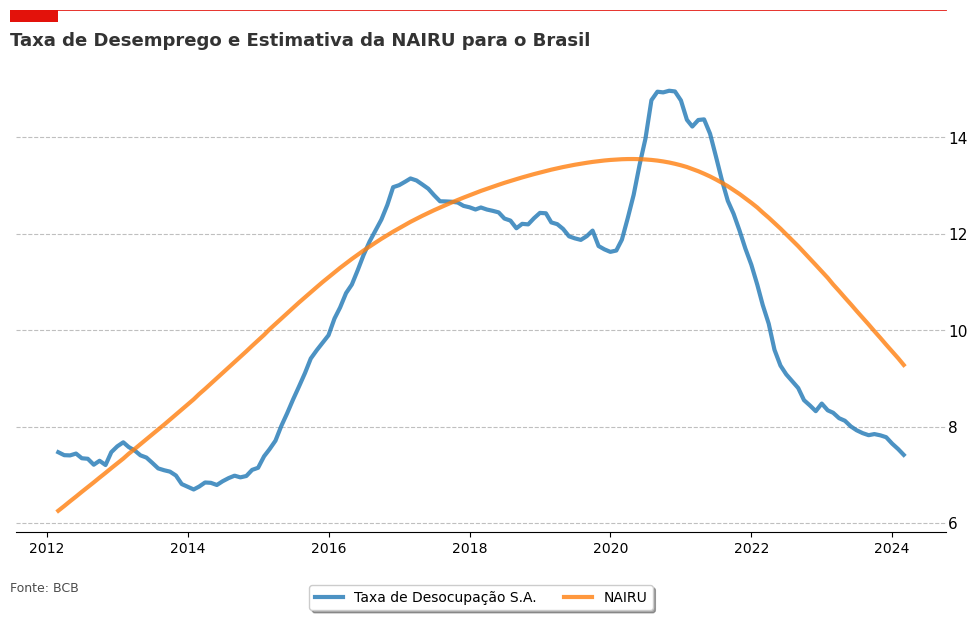

In [63]:
import matplotlib.pyplot as plt
import numpy as np

# Setup plot size.
fig, ax = plt.subplots(figsize=(12, 6))

# Loop through country names and plot each one with a different color.
for i, variable in enumerate(variables):
    color = plt.cm.tab10(i)  # Use a different color for each variable
    ax.plot(dados_long[dados_long['variable'] == variable]['Date'],
            dados_long[dados_long['variable'] == variable]['value'],
            color=color,
            alpha=0.8,
            linewidth=3,
            label=variable)  # Add label for legend

# Add legend below the plot.
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), shadow=True, ncol=len(variables))

######### Estética do Gráfico #########
# Remove splines. Can be done one at a time or can slice with a list.
ax.spines[['top', 'right', 'left']].set_visible(False)

ax.yaxis.grid(True, linestyle='--', which='major', color='gray', alpha=0.5)  # Add grid lines for y-axis

ax.yaxis.set_tick_params(pad=-2, labeltop=True, labelbottom=False, bottom=False, labelsize=11)

# Add in line and tag
ax.plot([0.12, .9], [.98, .98], transform=fig.transFigure, clip_on=False, color='#E3120B', linewidth=.6)
ax.add_patch(plt.Rectangle((0.12, .98), 0.04, -0.02, facecolor='#E3120B', transform=fig.transFigure, clip_on=False, linewidth=0))

# Add in title and subtitle
ax.text(x=0.12, y=.92, s="Taxa de Desemprego e Estimativa da NAIRU para o Brasil", transform=fig.transFigure, ha='left', fontsize=13, weight='bold', alpha=.8)
# Set source text
ax.text(x=0.12, y=0.01, s="""Fonte: BCB""", transform=fig.transFigure, ha='left', fontsize=9, alpha=.7)

plt.show()

In [67]:
# Cria hiato do desemprego
dados['hiato_pnad'] = dados.pnad_sa.values - dados.nairu.values

# Cria o gráfico
dados_hiato_long = (
            dados
            .rename(columns = {'ipca' : 'IPCA acumulado em 12 meses',
                              'hiato_pnad' : 'Taxa de Desocupação - NAIRU'})
            .reset_index()
            [['Date', 'Taxa de Desocupação - NAIRU', 'IPCA acumulado em 12 meses']]
            .melt(id_vars = ['Date'])
          )
dados_hiato_long

,Date,variable,value
0,2012-03-01,Taxa de Desocupação - NAIRU,1.213759
1,2012-04-01,Taxa de Desocupação - NAIRU,1.054377
2,2012-05-01,Taxa de Desocupação - NAIRU,0.951854
3,2012-06-01,Taxa de Desocupação - NAIRU,0.891838
4,2012-07-01,Taxa de Desocupação - NAIRU,0.696491
...,...,...,...
285,2023-11-01,IPCA acumulado em 12 meses,4.683537
286,2023-12-01,IPCA acumulado em 12 meses,4.621114
287,2024-01-01,IPCA acumulado em 12 meses,4.506637
288,2024-02-01,IPCA acumulado em 12 meses,4.496274


In [69]:
variables_2 = dados_hiato_long["variable"].unique()
variables_2

array(['Taxa de Desocupação - NAIRU', 'IPCA acumulado em 12 meses'],
      dtype=object)

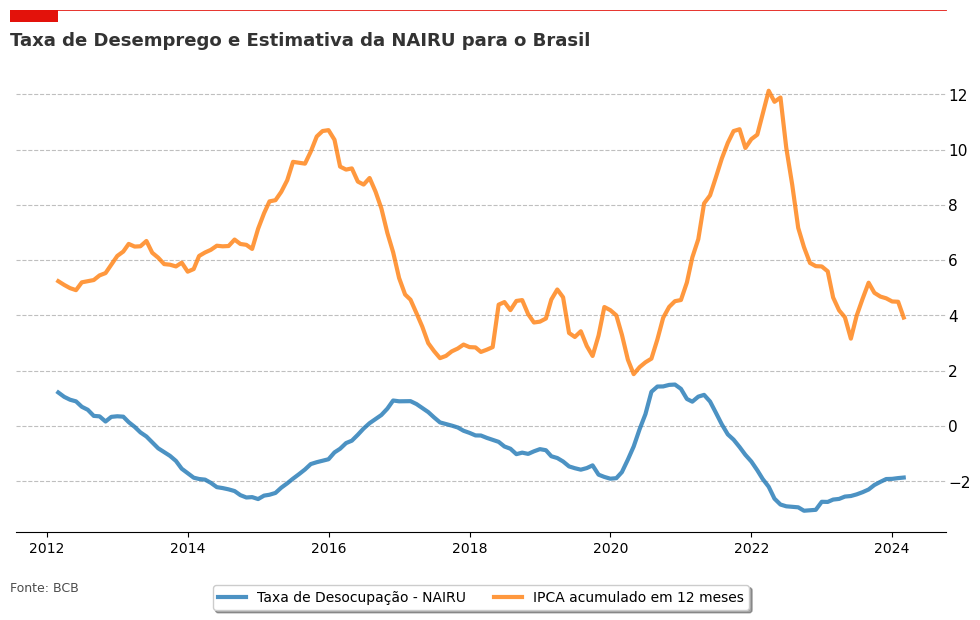

In [71]:
import matplotlib.pyplot as plt
import numpy as np

# Setup plot size.
fig, ax = plt.subplots(figsize=(12, 6))

# Loop through country names and plot each one with a different color.
for i, variable in enumerate(variables_2):
    color = plt.cm.tab10(i)  # Use a different color for each variable
    ax.plot(dados_hiato_long[dados_hiato_long['variable'] == variable]['Date'],
            dados_hiato_long[dados_hiato_long['variable'] == variable]['value'],
            color=color,
            alpha=0.8,
            linewidth=3,
            label=variable)  # Add label for legend

# Add legend below the plot.
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), shadow=True, ncol=len(variables_2))

######### Estética do Gráfico #########
# Remove splines. Can be done one at a time or can slice with a list.
ax.spines[['top', 'right', 'left']].set_visible(False)

ax.yaxis.grid(True, linestyle='--', which='major', color='gray', alpha=0.5)  # Add grid lines for y-axis

ax.yaxis.set_tick_params(pad=-2, labeltop=True, labelbottom=False, bottom=False, labelsize=11)

# Add in line and tag
ax.plot([0.12, .9], [.98, .98], transform=fig.transFigure, clip_on=False, color='#E3120B', linewidth=.6)
ax.add_patch(plt.Rectangle((0.12, .98), 0.04, -0.02, facecolor='#E3120B', transform=fig.transFigure, clip_on=False, linewidth=0))

# Add in title and subtitle
ax.text(x=0.12, y=.92, s="Taxa de Desemprego e Estimativa da NAIRU para o Brasil", transform=fig.transFigure, ha='left', fontsize=13, weight='bold', alpha=.8)
# Set source text
ax.text(x=0.12, y=0.01, s="""Fonte: BCB""", transform=fig.transFigure, ha='left', fontsize=9, alpha=.7)

plt.show()